# Phase estimation with CSS and SSS

In [431]:
# Importing standard Qiskit libraries
from qiskit import *
from qiskit.circuit.library import U1Gate, UnitaryGate, ZGate, XGate, HamiltonianGate
from qiskit.quantum_info import Operator
from qiskit.visualization import *
from qiskit_aer import AerSimulator
from qiskit.circuit.library import RealAmplitudes
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import * #Session, SamplerV2 as Sampler, QiskitRuntimeService, Result


 
#service = QiskitRuntimeService()

import qiskit.quantum_info as qi
from math import pi,log2,sqrt


# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="local")
#service = QiskitRuntimeService(channel="ibm_quantum", token="7daa54d02c4d0c593133ac851113fff5fa4b901a45e6965578ce9f2a2349ceba0a55c163216402411d45caffa06ca9b1460b93e648c32eb26bc76b0580d358ef")


In [432]:
import numpy as np
from scipy.linalg import expm
from statistics import variance

import matplotlib.pyplot as plt
from matplotlib import cm

import qutip as qt

In [433]:
#Pauli matrices
sx = qt.sigmax()
sy = qt.sigmay()
sz = qt.sigmaz()
id2 = qt.qeye(2)
base = [id2,sx,sy,sz]

In [434]:
def TotalSpin(N,direction): #direction = 1 for x, 2 for y, 3 for z
    output =  qt.Qobj([[0 for h in range(0,2**N)] for k in range(0,2**N)], dims=[[2 for h in range(0,N)], [2 for k in range (0,N)]])
    for i in range(0,N):
        output = output + qt.tensor([base[0] for h in range (0,i)]+[base[direction]]+[base[0] for h in range(i+1,N)])
    return(output)

In [435]:
def MaaStates(N,direction):
    ev = TotalSpin(N,direction).eigenstates()
    unitary = np.array([[ev[1][j][i][0] for i in range (0,2**N)] for j in range(0,2**N)])
    return(UnitaryGate(unitary,label='SSS basis'))

In [436]:
# Total spin operators as Qiskit operators
def TotalSpinOp(N,direction):
    dirs = 'IXYZ'
    output =  qi.Operator([[0 for h in range(0,2**N)] for k in range(0,2**N)])
    for i in range(0,N):
        string=''.join([dirs[0] for j in range(0,i)]+[dirs[direction]]+[dirs[0] for j in range(i+1,N)])
        output = output + qi.SparsePauliOp(string)
    return(output)

In [451]:
def SqueezingGate(N):
    mu = (24)**(1/6)*(N/2)**(-2/3)
    A = 1-np.cos(mu)**(N-2)
    B = 4*np.sin(mu/2)*np.cos(mu/2)**(N-2)
    delta = (1/2)*np.arctan(B/A)
    squeezing_strength = mu/2
    print(delta)
    #rotate Sx by -delta before using it as operator inside the squeezing Hamiltonian
    rot_spin_oper = (expm(1j * delta  * TotalSpinOp(N,3).to_matrix()) @ TotalSpinOp(N,1).to_matrix() @ expm(-1j * delta  * TotalSpinOp(N,3).to_matrix()))
    # The operator introducing the squeezing when applied to a coherent state, written as a Hamiltonian evolution
    sqz_op = HamiltonianGate( squeezing_strength * (rot_spin_oper @ rot_spin_oper), 1.0, label="Squeeze")
    return(sqz_op)

In [455]:
SqueezingGate(3).to_matrix()

0.6044501850867368


array([[ 0.82298054-0.34382767j,  0.        +0.j        ,
         0.        +0.j        , -0.19132529-0.17764146j,
         0.        +0.j        , -0.19132529-0.17764146j,
        -0.19132529-0.17764146j,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.82298054-0.34382767j,
         0.02572042+0.25980823j,  0.        +0.j        ,
         0.02572042+0.25980823j,  0.        +0.j        ,
         0.        +0.j        , -0.19132529-0.17764146j],
       [ 0.        +0.j        ,  0.02572042+0.25980823j,
         0.82298054-0.34382767j,  0.        +0.j        ,
         0.02572042+0.25980823j,  0.        +0.j        ,
         0.        +0.j        , -0.19132529-0.17764146j],
       [ 0.15278068-0.21170715j,  0.        +0.j        ,
         0.        +0.j        ,  0.82298054-0.34382767j,
         0.        +0.j        ,  0.02572042+0.25980823j,
         0.02572042+0.25980823j,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.02572042+0.25980823j,
         0

# CSS

We start just generating a coherent state in the $z$-axis direction, $|1\rangle ^{\otimes N}$, and measure the total $S_x$ spin, which is equivalent to measure all the individual qubit spins in the $x$ direction and add them (we will do the sum after running the circuit).

To measure the spin of individual qubits in each direction, we follow ```https://docs.quantum.ibm.com/guides/specify-observables-pauli```

In [438]:
def PM(N,dir): #Phase Measure
    PM = QuantumCircuit(N) 
    for i in range(0,N):
        PM.x(i) #CSS = |1> ^\tensor n
    for j in range(0,N):
        if dir==2:
            PM.sdg(j) #only form measuring sy
        if dir==1 or dir==2:
            PM.h(j) #measure sx or sy
    PM.measure_all()
    return(PM)

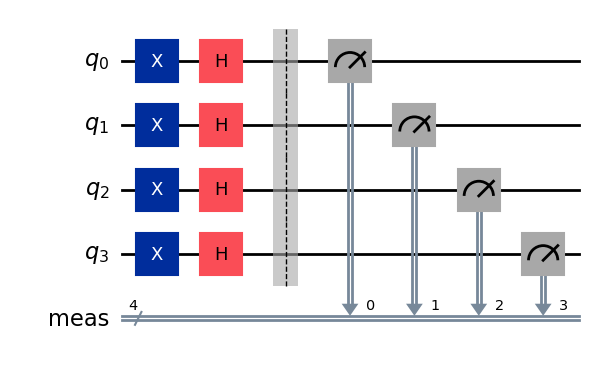

In [439]:
PM(4,1).draw()

# SSS

Now we generate the squeezed spin state of Kitagawa and Ueda (one-axis twisting ot OAT).
We do the squeezing in the $x$ direction, from the coherent state pointing along the $z$ axis.
But, to assure that the minimal and maximal variance occur when measuring $S_y$ and $S_x$, we
rotate the operator in the squeezing Hamiltonian by the twisting angle $-\delta$

In [440]:
#From Kitagawa and Ueda, page 5140


In [441]:
# Now we measure Sx in every qubit of the squeezed spin state, obtained by
# applying the squeezing operator to the CSS |1> ^{tensor N)
def SPM(N,dir):
    SPM= QuantumCircuit(N) #Squeezed Phase Measure
    for i in range(0,N):
        SPM.x(i) #CSS = |1> ^\tensor n
    SPM.append(SqueezingGate(N),range(0,N)) #squeezing
    for j in range(0,N):
        if dir==2:
            SPM.sdg(j) #only form measuring sy
        if dir==1 or dir==2:
            SPM.h(j) #measure sx or sy
    SPM.measure_all()
    return(SPM)

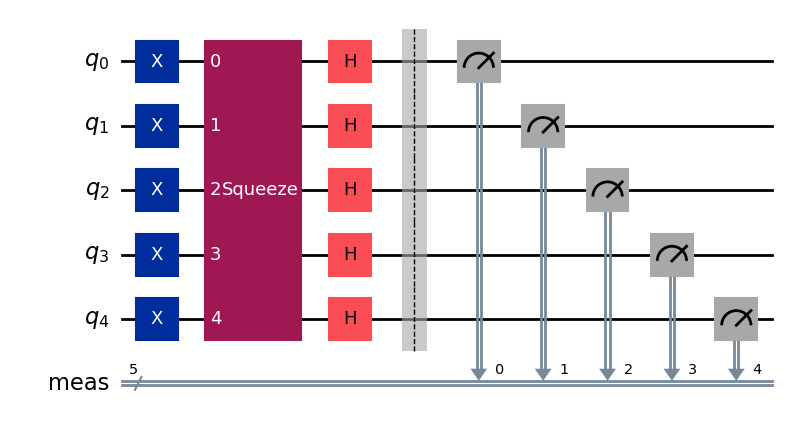

In [442]:
SPM(5,1).draw()

## Running the circuit


Let us get a histogram of the circuits.

In [443]:
# CSS
def RunCSS(N,dir,shotnumber,output): #output is "var" or "plot"
    aer_sim = AerSimulator()
    transpiled = transpile(PM(N,dir), aer_sim)
    result = aer_sim.run(transpiled, shots=shotnumber, memory=True).result()
    data = result.get_memory()
    output_list = []
    for res in data:
        output_list.append(N/2-res.count("0"))
    counts = dict()
    for item in output_list:
        counts[item] = counts.get(item, 0) + 1
    if output == "var":
        return(variance(output_list))
    if output == "plot":
        return(plot_histogram(counts))

In [444]:
#SSS OAT
# CSS
def RunSSS(N,dir,shotnumber,output): #output is "var" or "plot"
    aer_sim = AerSimulator()
    transpiled = transpile(SPM(N,dir), aer_sim)
    result = aer_sim.run(transpiled, shots=shotnumber, memory=True).result()
    data = result.get_memory()
    output_list = []
    for res in data:
        output_list.append(N/2-res.count("0"))
    counts = dict()
    for item in output_list:
        counts[item] = counts.get(item, 0) + 1
    if output == "var":
        return(variance(output_list))
    if output == "plot":
        return(plot_histogram(counts))

In [448]:
RunCSS(3,1,1024,"var")

0.7565638746334311

In [450]:
RunSSS(3,1,1024,"var")

0.6524315738025416

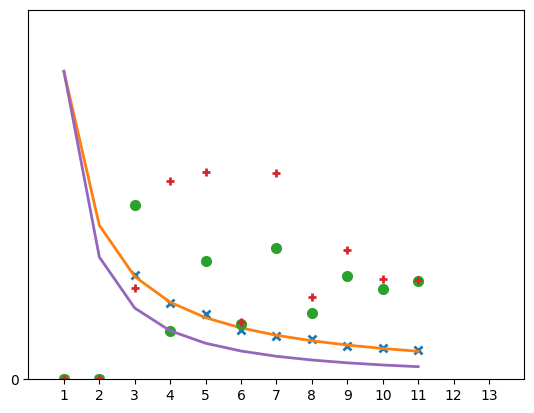

In [372]:
N=12
var=[0 for i in range(1,N)]
varsqy=[0 for i in range(1,N)]
varsqx=[0 for i in range(1,N)]
for j in range(2,N-1):
    var[j]=RunCSS(j+1,1024,"var")/(j+1)**2
    varsqy[j]=RunSSS(j+1,2,1024,"var")/(j+1)**2
    varsqx[j]=RunSSS(j+1,1,1024,"var")/(j+1)**2
x_axis=[i for i in range(1,N)]
th_var=[1/(4*i) for i in range (1,N)]
th_varsq=[1/(4*i**(4/3)) for i in range (1,N)]

fig, ax = plt.subplots()
ax.plot(x_axis, var, 'x', markeredgewidth=2)
ax.plot(x_axis, th_var, linewidth=2.0)
ax.plot(x_axis, varsqy, 'o', markeredgewidth=2)
ax.plot(x_axis, varsqx, '+', markeredgewidth=2)
ax.plot(x_axis, th_varsq, linewidth=2.0)
      
ax.set(xlim=(0, 14), xticks=np.arange(1, 14),
       ylim=(0, 0.3), yticks=np.arange(0, 0.5))
plt.show()

In [214]:
#SSS, Sx spin (max variance)
aer_sim2 = AerSimulator()
transpiled2 = transpile(SPMx, aer_sim2)
result = aer_sim2.run(transpiled2, shots=65536, memory=True).result()
data = result.get_memory()
statistics = result.get_counts()
output_list = []
for res in data:
    output_list.append(2-res.count("0"))
        
output = {i:0 for i in [-2,-1,0,1,2]}
output[-2] = statistics["0000"]
output[-1] = statistics["0001"]+statistics["0010"]+statistics["0100"]+statistics["1000"]
output[0] = statistics["0011"]+statistics["0101"]+statistics["0110"]+statistics["1001"]+statistics["1010"]+statistics["1100"]
output[1] = statistics["1110"]+statistics["1101"]+statistics["1011"]+statistics["1110"]
output[2] = statistics["1111"]

print(output)
print(variance(output_list))

{-2: 21119, -1: 432, 0: 22725, 1: 476, 2: 20790}
2.571635530960317


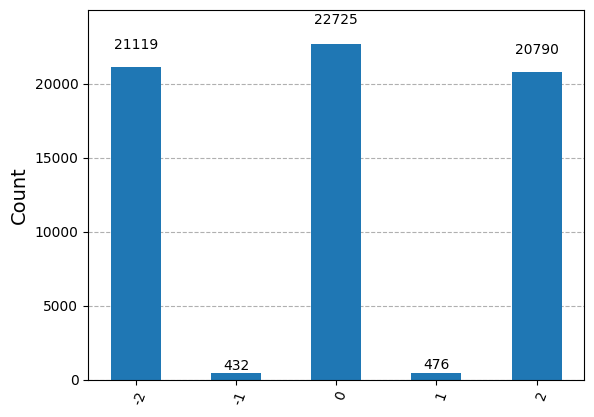

In [215]:
plot_histogram(output)

In [216]:
#SSS, Sy spin (min variance)
aer_sim2 = AerSimulator()
transpiled2 = transpile(SPMy, aer_sim2)
result = aer_sim2.run(transpiled2, shots=65536, memory=True).result()
data = result.get_memory()
statistics = result.get_counts()
output_list = []
for res in data:
    output_list.append(2-res.count("0"))
        
output = {i:0 for i in [-2,-1,0,1,2]}
output[-2] = statistics["0000"]
output[-1] = statistics["0001"]+statistics["0010"]+statistics["0100"]+statistics["1000"]
output[0] = statistics["0011"]+statistics["0101"]+statistics["0110"]+statistics["1001"]+statistics["1010"]+statistics["1100"]
output[1] = statistics["1110"]+statistics["1101"]+statistics["1011"]+statistics["1110"]
output[2] = statistics["1111"]

print(output)
print(variance(output_list))

{-2: 5302, -1: 422, 0: 54097, 1: 430, 2: 5296}
0.6596932412721822


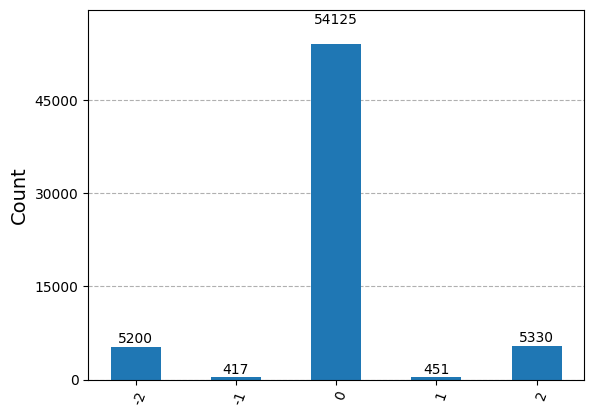

In [210]:
plot_histogram(output)